In [2]:
# --- 1. ÌôòÍ≤Ω ÏÑ§Ï†ï ÏÖÄ (ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ) ---
import os
import sys

# ÏûëÏóÖ ÎîîÎ†âÌÜ†Î¶¨Î•º Ïò¨Î∞îÎ•∏ ÏúÑÏπòÎ°ú Î≥ÄÍ≤Ω
workspace_path = '/workspace'
os.chdir(workspace_path)

# RFdiffusion Í≤ΩÎ°úÎ•º ÌååÏù¥Ïç¨Ïù¥ Ïù∏ÏãùÌïòÎèÑÎ°ù Ï∂îÍ∞Ä
rfdiffusion_path = os.path.join(workspace_path, 'RFdiffusion')
if rfdiffusion_path not in sys.path:
    sys.path.append(rfdiffusion_path)
import time
import signal
import sys
import random
import string
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

# ColabÏù¥ ÏïÑÎãå Î°úÏª¨ ÌôòÍ≤ΩÏù¥ÎØÄÎ°ú, RFdiffusion Í≤ΩÎ°úÎ•º ÏßÅÏ†ë Ï∂îÍ∞Ä
if 'RFdiffusion' not in sys.path:
    home_dir = os.path.expanduser("~")
    rfdiffusion_path = os.path.join(home_dir, 'RFdiffusion')
    sys.path.append(rfdiffusion_path)

os.environ["DGLBACKEND"] = "pytorch"

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

# --- ColabÏùò files.upload()Î•º ÎåÄÏ≤¥ÌïòÎäî Î°úÏª¨ ÌååÏùº Ï≤òÎ¶¨ Ìï®Ïàò ---
def get_pdb(pdb_code=None, use_upload=False):
    if use_upload:
        upload_widget = widgets.FileUpload(
            accept='.pdb', description='PDB ÌååÏùº ÏóÖÎ°úÎìú', button_style='info'
        )
        display(upload_widget)
        
        def wait_for_upload(widget):
            while len(widget.value) == 0: time.sleep(0.1)
            uploaded_filename = list(widget.value.keys())[0]
            pdb_content = widget.value[uploaded_filename]['content']
            pdb_filename = "tmp.pdb"
            with open(pdb_filename, "wb") as out: out.write(pdb_content)
            print(f"'{uploaded_filename}'Ïù¥(Í∞Ä) 'tmp.pdb'Î°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
            return pdb_filename
            
        return wait_for_upload(upload_widget)
    elif pdb_code is None or pdb_code == "":
        print("PDB ÏΩîÎìúÎ•º ÏûÖÎ†•ÌïòÍ±∞ÎÇò use_upload=TrueÎ°ú ÏÑ§Ï†ïÌïòÏÑ∏Ïöî.")
        return None
    elif os.path.isfile(pdb_code): return pdb_code
    elif len(pdb_code) == 4:
        pdb_filename = f"{pdb_code}.pdb1"
        if not os.path.isfile(pdb_filename):
            os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz && gunzip -f {pdb_code}.pdb1.gz")
        return pdb_filename
    else:
        pdb_filename = f"AF-{pdb_code}-F1-model_v4.pdb"
        if not os.path.isfile(pdb_filename):
            os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/{pdb_filename}")
        return pdb_filename

def run_ananas(pdb_str, path, sym=None):
    pdb_filename = f"outputs/{path}/ananas_input.pdb"
    out_filename = f"outputs/{path}/ananas.json"
    os.makedirs(f"outputs/{path}", exist_ok=True)
    with open(pdb_filename,"w") as handle: handle.write(pdb_str)
    cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
    if sym is None: os.system(cmd)
    else: os.system(f"{cmd} {sym}")
    try:
        with open(out_filename,"r") as f: out = json.load(f)
        results, AU = out[0], out[-1]["AU"]
        group, chains, rmsd = AU["group"], AU["chain names"], results["Average_RMSD"]
        print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")
        C = np.array(results['transforms'][0]['CENTER'])
        A = [np.array(t["AXIS"]) for t in results['transforms']]
        new_lines = []
        for line in pdb_str.split("\n"):
            if line.startswith("ATOM"):
                chain = line[21:22]
                if chain in chains:
                    x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
                    if group[0] == "c": x = sym_it(x,C,A[0])
                    if group[0] == "d": x = sym_it(x,C,A[1],A[0])
                    coord_str = "".join([f"{a:8.3f}" for a in x])
                    new_lines.append(line[:30]+coord_str+line[54:])
            else: new_lines.append(line)
        return results, "\n".join(new_lines)
    except Exception as e:
        print(f"AnAnaS Í≤∞Í≥º Ï≤òÎ¶¨ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
        return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):
    def run_command_and_get_pid(command):
        pid_file = '/dev/shm/pid'
        os.system(f'nohup {command} > /dev/null & echo $! > {pid_file}')
        with open(pid_file, 'r') as f: pid = int(f.read().strip())
        os.remove(pid_file)
        return pid
    def is_process_running(pid):
        try: os.kill(pid, 0)
        except OSError: return False
        else: return True
    run_output = widgets.Output()
    progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
    display(widgets.VBox([progress, run_output]))
    for n in range(steps):
        if os.path.isfile(f"/dev/shm/{n}.pdb"): os.remove(f"/dev/shm/{n}.pdb")
    pid = run_command_and_get_pid(command)
    try:
        fail = False
        for _ in range(num_designs):
            for n in range(steps):
                wait = True
                while wait and not fail:
                    time.sleep(0.1)
                    if os.path.isfile(f"/dev/shm/{n}.pdb"):
                        with open(f"/dev/shm/{n}.pdb", "r") as f: pdb_str = f.read()
                        if "TER" in pdb_str or "ENDMDL" in pdb_str: wait = False
                        elif not is_process_running(pid): fail = True
                    elif not is_process_running(pid): fail = True
                if fail:
                    progress.bar_style = 'danger'; progress.description = "failed"
                    break
                else:
                    progress.value = (n+1) / steps
                    if visual != "none":
                        with run_output:
                            run_output.clear_output(wait=True)
                            if visual == "image":
                                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                                fig = plt.figure(); fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1); plt.show()
                            if visual == "interactive":
                                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                                view.addModel(pdb_str,'pdb'); view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                                view.zoomTo(); view.show()
                if os.path.exists(f"/dev/shm/{n}.pdb"): os.remove(f"/dev/shm/{n}.pdb")
            if fail:
                progress.bar_style = 'danger'; progress.description = "failed"
                break
        while is_process_running(pid): time.sleep(0.1)
    except KeyboardInterrupt:
        os.kill(pid, signal.SIGTERM); progress.bar_style = 'danger'; progress.description = "stopped"
    
def run_diffusion(contigs, path, pdb=None, iterations=50, symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, num_designs=1, visual="none"):
    full_path = f"outputs/{path}"; os.makedirs(full_path, exist_ok=True)
    opts = [f"inference.output_prefix={full_path}", f"inference.num_designs={num_designs}"]
    if chains == "": chains = None
    if symmetry in ["auto","cyclic","dihedral"]:
        if symmetry == "auto": sym, copies = None, 1
        else: sym, copies = {"cyclic":(f"c{order}",order), "dihedral":(f"d{order}",order*2)}[symmetry]
    else: symmetry = None; sym, copies = None, 1
    contigs_list = contigs.replace(","," ").replace(":"," ").split()
    is_fixed, is_free = False, False; fixed_chains = []
    for contig in contigs_list:
        for x in contig.split("/"):
            a = x.split("-")[0]
            if a and a[0].isalpha():
                is_fixed = True
                if a[0] not in fixed_chains: fixed_chains.append(a[0])
            if a.isnumeric(): is_free = True
    if len(contigs_list) == 0 or not is_free: mode = "partial"
    elif is_fixed: mode = "fixed"
    else: mode = "free"
    if mode in ["partial","fixed"]:
        pdb_str = pdb_to_string(pdb, chains=chains)
        if symmetry == "auto":
            a, pdb_str = run_ananas(pdb_str, path)
            if a is None: print(f'ERROR: no symmetry detected'); symmetry = None; sym, copies = None, 1
            else:
                if a["group"][0] == "c": symmetry = "cyclic"; sym, copies = a["group"], int(a["group"][1:])
                elif a["group"][0] == "d": symmetry = "dihedral"; sym, copies = a["group"], 2 * int(a["group"][1:])
                else: print(f'ERROR: detected symm ({a["group"]}) not supported'); symmetry = None; sym, copies = None, 1
        elif mode == "fixed": pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)
        pdb_filename = f"{full_path}/input.pdb"
        with open(pdb_filename, "w") as handle: handle.write(pdb_str)
        parsed_pdb = parse_pdb(pdb_filename)
        opts.append(f"inference.input_pdb={pdb_filename}")
        if mode in ["partial"]:
            iterations = int(80 * (iterations / 200)); opts.append(f"diffuser.partial_T={iterations}")
            contigs_list = fix_partial_contigs(contigs_list, parsed_pdb)
        else: opts.append(f"diffuser.T={iterations}"); contigs_list = fix_contigs(contigs_list, parsed_pdb)
    else:
        opts.append(f"diffuser.T={iterations}"); parsed_pdb = None
        contigs_list = fix_contigs(contigs_list, parsed_pdb)
    if hotspot is not None and hotspot != "": opts.append(f"ppi.hotspot_res=[{hotspot}]")
    if sym is not None:
        sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
        if add_potential: sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'", "potentials.olig_intra_all=True","potentials.olig_inter_all=True", "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
        opts = sym_opts + opts; contigs_list = sum([contigs_list] * copies,[])
    opts.append(f"'contigmap.contigs=[{' '.join(contigs_list)}]'")
    opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
    print("mode:", mode); print("output:", full_path); print("contigs:", contigs_list)
    run_script_path = "/workspace/RFdiffusion/run_inference.py"
    opts_str = " ".join(opts)
    cmd = f"python {run_script_path} {opts_str}"
    print(cmd)
    run(cmd, iterations, num_designs, visual=visual)
    for n in range(num_designs):
        pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb", f"outputs/traj/{path}_{n}_Xt-1_traj.pdb", f"{full_path}_{n}.pdb"]
        for pdb_file in pdbs:
            if os.path.exists(pdb_file):
                with open(pdb_file,"r") as handle: pdb_str = handle.read()
                with open(pdb_file,"w") as handle: handle.write(fix_pdb(pdb_str, contigs_list))
    return contigs_list, copies

print("‚úÖ Setup cell is ready.")

‚úÖ Setup cell is ready.


‚úÖ Í≤∞Í≥ºÍ∞Ä Ï†ÄÏû•Îê† Ìè¥Îçî: outputs/0825-50-600_9b08r
mode: fixed
output: outputs/0825-50-600_9b08r/0825-50-600_9b08r
contigs: ['C311-391', '100-100']
python /workspace/RFdiffusion/run_inference.py inference.output_prefix=outputs/0825-50-600_9b08r/0825-50-600_9b08r inference.num_designs=600 inference.input_pdb=outputs/0825-50-600_9b08r/0825-50-600_9b08r/input.pdb diffuser.T=50 ppi.hotspot_res=[C331,C360,C378,C381,C323] 'contigmap.contigs=[C311-391 100-100]' inference.dump_pdb=True inference.dump_pdb_path='/dev/shm'


/workspace/RFdiffusion/util_module.py:259: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/Cross.cpp:62.)
  CBrotaxis1 = (CBr-CAr).cross(NCr-CAr)


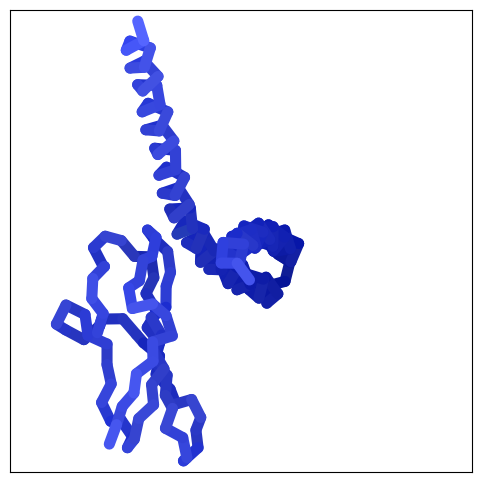

In [ ]:
# --- Î∞îÏù∏Îçî ÎîîÏûêÏù∏ Ïã§Ìñâ ÏÖÄ (ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ) ---

# 1. ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
name = "0825-50-600"
contigs = "C311-391/0 100-100"
hotspot = "C331,C360,C378,C381,C323"
iterations = 50
num_designs = 600
visual = "image"

# --- 2. ÏóÖÎ°úÎìúÌïú PDB ÌååÏùº Í≤ΩÎ°ú ÏßÅÏ†ë ÏßÄÏ†ï ---
# Ïó¨Í∏∞Ïóê 1Îã®Í≥ÑÏóêÏÑú ÏóÖÎ°úÎìúÌïú PDB ÌååÏùºÏùò Ï†ïÌôïÌïú Ïù¥Î¶ÑÏùÑ ÏûÖÎ†•ÌïòÏÑ∏Ïöî.
pdb_filename = "4k9e_c.pdb" 
pdb = os.path.join("/workspace", pdb_filename)

# 3. RFdiffusion Ïã§Ìñâ
# --- Ïù¥ ÏïÑÎû´Î∂ÄÎ∂ÑÏù¥ ÏàòÏ†ïÎêòÏóàÏäµÎãàÎã§ ---

# Í∏∞Î≥∏ Ïã§Ìñâ Ïù¥Î¶Ñ(Ìè¥ÎçîÎ™ÖÏúºÎ°ú ÏÇ¨Ïö©Îê†)ÏùÑ ÏÑ§Ï†ïÌï©ÎãàÎã§.
base_name = name
output_dir = f"outputs/{base_name}"

# ÎßåÏïΩ ÎèôÏùºÌïú Ïù¥Î¶ÑÏùò Ìè¥ÎçîÍ∞Ä Ïù¥ÎØ∏ Ï°¥Ïû¨ÌïòÎ©¥, Ï§ëÎ≥µÏùÑ ÌîºÌïòÍ∏∞ ÏúÑÌï¥ ÎûúÎç§ Î¨∏ÏûêÏó¥ÏùÑ Îí§Ïóê Î∂ôÏûÖÎãàÎã§.
while os.path.exists(output_dir):
    random_suffix = ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))
    base_name = f"{name}_{random_suffix}"
    output_dir = f"outputs/{base_name}"

# run_diffusion Ìï®ÏàòÎäî Ïù¥ pathÎ•º ÌååÏùº Ïù¥Î¶ÑÏùò Ï†ëÎëêÏÇ¨Î°ú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
# Ïòà: pathÍ∞Ä "8051/8051" Ïù¥Î©¥, Í≤∞Í≥ºÎäî outputs/8051/8051_0.pdb Î°ú Ï†ÄÏû•Îê©ÎãàÎã§.
path = os.path.join(base_name, base_name)

print(f"‚úÖ Í≤∞Í≥ºÍ∞Ä Ï†ÄÏû•Îê† Ìè¥Îçî: {output_dir}")
# --- ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ ÎÅù ---


flags = {
    "contigs": contigs, "pdb": pdb, "iterations": int(iterations),
    "hotspot": hotspot, "path": path, "num_designs": int(num_designs),
    "visual": visual, "symmetry": "none", "order": 1, "chains": "", "add_potential": True
}

for k, v in flags.items():
    if isinstance(v, str):
        flags[k] = v.replace("'", "").replace('"', '')

contigs, copies = run_diffusion(**flags)

# --- ÎßàÏßÄÎßâ Ï∂úÎ†• Î©îÏãúÏßÄÎèÑ ÏàòÏ†ïÎêòÏóàÏäµÎãàÎã§ ---
print(f"‚úÖ RFdiffusion Ïã§Ìñâ ÏôÑÎ£å! Í≤∞Í≥ºÎäî '{output_dir}' Ìè¥ÎçîÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

In [ ]:
# ÏïÑÎûò ÏΩîÎìúÎäî backboneÎßå ÏûàÏñ¥ÎèÑ proteinmpnn,colabdesignÏùÑ Ïã§ÌñâÏãúÏºúÏ£ºÎäî ÏΩîÎìú * ÏΩîÎìú Ïù¥ÏÉÅÌï® Îã§Ïãú ÏßúÍ∏∞ *

In [3]:
# --- [ÌååÏùº Ïù¥Î¶Ñ Ï†ïÎ¶¨ ÏΩîÎìú] ---
import os
import glob
import re

# @markdown ### **üëá Ï†ïÎ¶¨Ìï† RFdiffusion Ïã§Ìñâ Ìè¥Îçî Ïù¥Î¶ÑÏùÑ ÏûÖÎ†•ÌïòÏÑ∏Ïöî.**
run_name = "0826-50-600_ocr8j"  # @param {type:"string"}

# --- ÏïÑÎûò ÏΩîÎìúÎäî Í∑∏ÎåÄÎ°ú Ïã§ÌñâÌïòÎ©¥ Îê©ÎãàÎã§. ---

# ÎåÄÏÉÅ Ìè¥Îçî Í≤ΩÎ°ú ÏÑ§Ï†ï
target_dir = os.path.join("outputs", run_name)

if not os.path.isdir(target_dir):
    print(f"üö® ÏóêÎü¨: '{target_dir}' Ìè¥ÎçîÎ•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. 'run_name'ÏùÑ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")
else:
    # Ìï¥Îãπ Ìè¥Îçî ÎÇ¥Ïùò Î™®Îì† pdb ÌååÏùº Î™©Î°ùÏùÑ Í∞ÄÏ†∏ÏòµÎãàÎã§.
    pdb_files = sorted(glob.glob(os.path.join(target_dir, f"{run_name}_*.pdb")))
    
    if not pdb_files:
        print(f"üö® ÏóêÎü¨: '{target_dir}' Ìè¥ÎçîÏóêÏÑú PDB ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
    else:
        print(f"‚úÖ Ï¥ù {len(pdb_files)}Í∞úÏùò PDB ÌååÏùºÏùÑ Ï∞æÏïòÏäµÎãàÎã§. ÌååÏùº Ïù¥Î¶Ñ Î≥ÄÍ≤ΩÏùÑ ÏãúÏûëÌï©ÎãàÎã§...")
        
        # ÏÉàÎ°úÏö¥ Î≤àÌò∏Î°ú ÌååÏùº Ïù¥Î¶ÑÏùÑ Î≥ÄÍ≤ΩÌï©ÎãàÎã§.
        for i, old_pdb_path in enumerate(pdb_files):
            # ÏÉà ÌååÏùº Í≤ΩÎ°ú ÏÉùÏÑ± (Ïòà: .../run_name_0.pdb)
            new_pdb_path = os.path.join(target_dir, f"{run_name}_{i}.pdb")
            
            # Ïó∞Í¥ÄÎêú .trb ÌååÏùº Í≤ΩÎ°úÎèÑ ÏÉùÏÑ±
            old_trb_path = old_pdb_path.replace(".pdb", ".trb")
            new_trb_path = new_pdb_path.replace(".pdb", ".trb")
            
            # ÌååÏùº Ïù¥Î¶Ñ Î≥ÄÍ≤Ω Ïã§Ìñâ
            if old_pdb_path != new_pdb_path:
                print(f"  - Renaming {os.path.basename(old_pdb_path)} -> {os.path.basename(new_pdb_path)}")
                os.rename(old_pdb_path, new_pdb_path)
            
            if os.path.exists(old_trb_path) and old_trb_path != new_trb_path:
                print(f"  - Renaming {os.path.basename(old_trb_path)} -> {os.path.basename(new_trb_path)}")
                os.rename(old_trb_path, new_trb_path)

        print("\n‚úÖ ÌååÏùº Ïù¥Î¶Ñ Ï†ïÎ¶¨Í∞Ä ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§. Ïù¥Ï†ú Í≤ÄÏ¶ù Ïä§ÌÅ¨Î¶ΩÌä∏Î•º Ïã§ÌñâÌï† Ïàò ÏûàÏäµÎãàÎã§.")

‚úÖ Ï¥ù 600Í∞úÏùò PDB ÌååÏùºÏùÑ Ï∞æÏïòÏäµÎãàÎã§. ÌååÏùº Ïù¥Î¶Ñ Î≥ÄÍ≤ΩÏùÑ ÏãúÏûëÌï©ÎãàÎã§...
  - Renaming 0826-50-600_ocr8j_10.pdb -> 0826-50-600_ocr8j_2.pdb
  - Renaming 0826-50-600_ocr8j_10.trb -> 0826-50-600_ocr8j_2.trb
  - Renaming 0826-50-600_ocr8j_100.pdb -> 0826-50-600_ocr8j_3.pdb
  - Renaming 0826-50-600_ocr8j_100.trb -> 0826-50-600_ocr8j_3.trb
  - Renaming 0826-50-600_ocr8j_101.pdb -> 0826-50-600_ocr8j_4.pdb
  - Renaming 0826-50-600_ocr8j_101.trb -> 0826-50-600_ocr8j_4.trb
  - Renaming 0826-50-600_ocr8j_102.pdb -> 0826-50-600_ocr8j_5.pdb
  - Renaming 0826-50-600_ocr8j_102.trb -> 0826-50-600_ocr8j_5.trb
  - Renaming 0826-50-600_ocr8j_103.pdb -> 0826-50-600_ocr8j_6.pdb
  - Renaming 0826-50-600_ocr8j_103.trb -> 0826-50-600_ocr8j_6.trb
  - Renaming 0826-50-600_ocr8j_104.pdb -> 0826-50-600_ocr8j_7.pdb
  - Renaming 0826-50-600_ocr8j_104.trb -> 0826-50-600_ocr8j_7.trb
  - Renaming 0826-50-600_ocr8j_105.pdb -> 0826-50-600_ocr8j_8.pdb
  - Renaming 0826-50-600_ocr8j_105.trb -> 0826-50-60

In [2]:
# --- Top n ÎîîÏûêÏù∏ÏùÑ ÏÑ†Î≥ÑÌïòÍ≥† PDB ÌååÏùºÏùÑ ÏÉùÏÑ±ÌïòÎäî ÏÖÄ ---

import pandas as pd
import os
import shutil

# 1. Í≤∞Í≥º ÌååÏùº Î∞è Í≤ΩÎ°ú ÏÑ§Ï†ï (Ïù¥ Î∂ÄÎ∂ÑÏùÄ Ïù¥ÎØ∏ Ïò¨Î∞îÎ•¥Í≤å ÏàòÏ†ïÎêòÏóàÏäµÎãàÎã§)
results_csv_path = "outputs/0825-50-600_9b08r/0825-50-600_9b08r/mpnn_results.csv"
source_pdb_folder = "outputs/0825-50-600_9b08r/0825-50-600_9b08r"
ranked_pdb_folder = "outputs/0825-50-600_9b08r/0825-50-600_9b08r/ranked_top_100"

print(f"'{results_csv_path}' ÌååÏùºÏóêÏÑú Í≤∞Í≥º Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§.")

# 2. Í≤∞Í≥º ÌååÏùºÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
if not os.path.exists(results_csv_path):
    print(f" ÏóêÎü¨: Í≤∞Í≥º ÌååÏùº({results_csv_path})ÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. Ïù¥Ï†Ñ ÏÖÄÏù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Ïã§ÌñâÎêòÏóàÎäîÏßÄ ÌôïÏù∏ÌïòÏÑ∏Ïöî.")
else:
    # 3. CSV ÌååÏùº ÏùΩÏñ¥Ïò§Í∏∞
    df_all = pd.read_csv(results_csv_path)
    
    # 4. i_pae < 10 Ï°∞Í±¥ÏúºÎ°ú ÌïÑÌÑ∞ÎßÅ
    #    'i_pae' Ïª¨ÎüºÏù¥ Ï°¥Ïû¨ÌïòÎØÄÎ°ú Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    if 'i_pae' in df_all.columns:
        df_filtered = df_all[df_all['i_pae'] < 10].copy()
        print(f"i_pae < 10 Ï°∞Í±¥ÏùÑ ÎßåÏ°±ÌïòÎäî ÎîîÏûêÏù∏ {len(df_filtered)}Í∞úÎ•º Ï∞æÏïòÏäµÎãàÎã§.")
    else:
        print(" Í≤ΩÍ≥†: 'i_pae' Ïª¨ÎüºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. ÌïÑÌÑ∞ÎßÅ ÏóÜÏù¥ Î™®Îì† ÎîîÏûêÏù∏ÏúºÎ°ú ÏßÑÌñâÌï©ÎãàÎã§.")
        df_filtered = df_all.copy()

    # 5. RMSD Í∏∞Ï§ÄÏúºÎ°ú Ïò§Î¶ÑÏ∞®Ïàú Ï†ïÎ†¨
    df_sorted = df_filtered.sort_values(by='rmsd', ascending=True)

    # 6. ÏÉÅÏúÑ 100Í∞ú ÎîîÏûêÏù∏ ÏÑ†ÌÉù
    top_100_designs = df_sorted.head(100)
    print(f"RMSDÍ∞Ä ÎÇÆÏùÄ ÏàúÏÑúÎåÄÎ°ú ÏÉÅÏúÑ {len(top_100_designs)}Í∞úÎ•º ÏÑ†Î≥ÑÌñàÏäµÎãàÎã§.")

    # 7. ÏàúÏúÑÎ≥Ñ PDB ÌååÏùºÏùÑ Ï†ÄÏû•Ìï† Ìè¥Îçî ÏÉùÏÑ±
    os.makedirs(ranked_pdb_folder, exist_ok=True)
    print(f"ÏÑ†Î≥ÑÎêú PDB ÌååÏùºÏùÄ '{ranked_pdb_folder}' Ìè¥ÎçîÏóê Ï†ÄÏû•Îê©ÎãàÎã§.")

    # 8. PDB ÌååÏùº Î≥µÏÇ¨ Î∞è Ïù¥Î¶Ñ Î≥ÄÍ≤Ω
    copied_count = 0
    for rank, (index, row) in enumerate(top_100_designs.iterrows(), 1):
        # 'design'Í≥º 'n' Ïª¨ÎüºÏùÑ Ï°∞Ìï©ÌïòÏó¨ ÌååÏùºÎ™Ö ÏÉùÏÑ±
        design_name = f"design{row['design']}_n{row['n']}"  # Ïù¥ Î∂ÄÎ∂ÑÏùÑ ÏàòÏ†ï
        source_pdb_file = f"{source_pdb_folder}/{design_name}.pdb"
        
        # ÏàúÏúÑÎ•º Ìè¨Ìï®Ìïú ÏÉàÎ°úÏö¥ ÌååÏùºÎ™Ö ÏßÄÏ†ï
        rmsd_val = row['rmsd']
        dest_pdb_file = f"{ranked_pdb_folder}/rank_{rank:03d}_{design_name}_rmsd_{rmsd_val:.2f}.pdb"

        if os.path.exists(source_pdb_file):
            shutil.copy(source_pdb_file, dest_pdb_file)
            copied_count += 1
        else:
            print(f"  - Í≤ΩÍ≥†: ÏõêÎ≥∏ ÌååÏùº '{source_pdb_file}'ÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")

    print(f"\n‚úÖ ÏûëÏóÖ ÏôÑÎ£å: Ï¥ù {copied_count}Í∞úÏùò PDB ÌååÏùºÏùÑ ÏàúÏúÑÎ≥ÑÎ°ú Ï†ÄÏû•ÌñàÏäµÎãàÎã§.")
    
    # 9. ÏÑ†Î≥ÑÎêú Top 100 ÎîîÏûêÏù∏Ïùò ÌÜµÍ≥Ñ Ï†ïÎ≥¥ Ï∂úÎ†•
    # 'name' ÎåÄÏã† 'plddt', 'i_pae', 'rmsd' Ïª¨ÎüºÏùÑ Ï∂úÎ†•Ìï©ÎãàÎã§. 'design'Í≥º 'n'ÎèÑ Ìè¨Ìï®Ìï©ÎãàÎã§.
    print("\nüìä ÏÑ†Î≥ÑÎêú Top 100 ÎîîÏûêÏù∏ Î™©Î°ù:")
    print(top_100_designs[['design', 'n', 'plddt', 'i_pae', 'rmsd']].to_string(index=False)) # Ïù¥ Î∂ÄÎ∂ÑÏùÑ ÏàòÏ†ï

'outputs/0825-50-600_9b08r/0825-50-600_9b08r/mpnn_results.csv' ÌååÏùºÏóêÏÑú Í≤∞Í≥º Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§.
i_pae < 10 Ï°∞Í±¥ÏùÑ ÎßåÏ°±ÌïòÎäî ÎîîÏûêÏù∏ 18Í∞úÎ•º Ï∞æÏïòÏäµÎãàÎã§.
RMSDÍ∞Ä ÎÇÆÏùÄ ÏàúÏÑúÎåÄÎ°ú ÏÉÅÏúÑ 18Í∞úÎ•º ÏÑ†Î≥ÑÌñàÏäµÎãàÎã§.
ÏÑ†Î≥ÑÎêú PDB ÌååÏùºÏùÄ 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/ranked_top_100' Ìè¥ÎçîÏóê Ï†ÄÏû•Îê©ÎãàÎã§.
  - Í≤ΩÍ≥†: ÏõêÎ≥∏ ÌååÏùº 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design553_n0.pdb'ÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.
  - Í≤ΩÍ≥†: ÏõêÎ≥∏ ÌååÏùº 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design553_n4.pdb'ÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.
  - Í≤ΩÍ≥†: ÏõêÎ≥∏ ÌååÏùº 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design553_n1.pdb'ÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.
  - Í≤ΩÍ≥†: ÏõêÎ≥∏ ÌååÏùº 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design553_n2.pdb'ÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.
  - Í≤ΩÍ≥†: ÏõêÎ≥∏ ÌååÏùº 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design553_n7.pdb'ÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.
  - Í≤ΩÍ≥†: ÏõêÎ≥∏ ÌååÏùº 'outputs/0825-50-600_9b08r/0825-5